## Set up Environment

In [1]:
# Modify the pathname

pathname = '/content/drive/MyDrive/MMAI/MMAI 869 - Machine Learning/Pump It Up - Project/'

In [2]:
# Connect and Mount your Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Set Seed 

seed_value=123

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [4]:
# install packages

%%capture
!pip install optuna

In [5]:
# Import libraries

import pandas as pd

from lightgbm import LGBMClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

import datetime as dt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)


## Data Preprocessing

In [6]:
def load_data():

    X_train_ = pd.read_csv(pathname+'Train_X.csv')
    y_train_ = pd.read_csv(pathname+'Train_Y.csv')
    X_test_ = pd.read_csv(pathname+'Test_X.csv')
    
    return X_train_, y_train_, X_test_

X_train, y_train, X_test = load_data()

In [7]:
def preprocessing_1(X, y=None):
    
    ## drop id column
    X_id = X['id']
    X.drop(columns='id',inplace=True)
    if y is not None:
        y.drop(columns='id',inplace=True)
        
    ## drop cols
    X.drop(columns=['wpt_name', 'subvillage', 'region_code', 'district_code', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type_group', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group'], inplace=True)
    
    ## combine categories
    X.loc[X['waterpoint_type']=='dam', 'waterpoint_type'] = 'cattle_dam'
    X.loc[X['waterpoint_type']=='cattle trough', 'waterpoint_type'] = 'cattle_dam'
    
    ## change 0 to missing
    X.loc[X['construction_year']==0, 'construction_year'] = np.nan
    
    ## change binary columns to numeric
    X.loc[X['permit']==False, 'permit'] = 0
    X.loc[X['permit']==True, 'permit'] = 1
    X['permit'] = X['permit'].astype(float)
    X.loc[X['public_meeting']==False, 'public_meeting'] = 0
    X.loc[X['public_meeting']==True, 'public_meeting'] = 1
    X['public_meeting'] = X['public_meeting'].astype(float)
    
    ## clean category
    X.loc[X['installer']=='Communit', 'installer'] = 'Commu'
    X.loc[X['installer']=='Community', 'installer'] = 'Commu'
    X.loc[X['installer']=='Central govt', 'installer'] = 'Central Government'
    
    ## create month_recorded feature
    import datetime as dt
    X['month_recorded'] = pd.to_datetime(X['date_recorded']).dt.month.astype(object)
    
    ## date to days
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['date_recorded'] = (X['date_recorded'] - pd.to_datetime('1900-01-01')).dt.days
    
    ## rare category grouping
    non_rare_cat = {'funder':['Danida','Germany Republi','Government Of Tanzania','Hesawa','Kkkt','Private Individual','Rwssp','World Bank','World Vision'], 
                'installer':['Central Government','CES','Commu','Danid','DWE','Government','HESAWA','RWE','World Vision'],
                'lga':['Arusha Rural','Bagamoyo','Bariadi','Hai','Iringa Rural','Kahama','Kasulu','Kibondo','Kigoma Rural','Kilombero','Kilosa','Kyela','Magu','Makete','Mbozi','Meru','Moshi Rural','Mpanda','Mvomero','Njombe','Rombo','Rungwe','Same','Singida Rural'],
                'extraction_type':['afridev','gravity','india mark ii','ksb','mono','nira/tanira','other','submersible','swn 80'],
                'management':['vwc','wug','water board','wua','private operator','parastatal','company','unknown']
                }
    for c in non_rare_cat:
        X.loc[~X[c].isin(non_rare_cat[c]), c] = 'Rare'
    
    ## change column type for input to Light GBM
    X[X.select_dtypes(include='object').columns] = X[X.select_dtypes(include='object').columns].astype('category')
    
    if y is not None:
        y = y.iloc[:,0].values.ravel()
     
    return X, y, X_id
    
X_train, y_train, train_id = preprocessing_1(X_train, y_train)
X_test, y_test, test_id = preprocessing_1(X_test)  # y_test returns None

In [8]:
def remove_class_outliers(X,y,k,threshold):
    
    X_scaled = X.copy()
    X_org = X.copy()
    
    ## fill missing values temporarily
    numeric_columns = X_scaled.select_dtypes(include=['number']).columns
    X_scaled[numeric_columns] = X_scaled[numeric_columns].fillna(X_scaled.median(axis=0))
    X_scaled = X_scaled.fillna(X_scaled.mode().iloc[0])
    
    ## OH encode temporarily
    X_scaled = pd.get_dummies(X_scaled, drop_first = False)
    
    ## standardize features temporarily
    scaler = StandardScaler()
    scaler.fit(X_scaled)
    X_scaled.iloc[:,:] = scaler.transform(X_scaled)
    
    ## Find kNN for each data point
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_scaled)
    distances, indices = nbrs.kneighbors(X_scaled)
  
    indices = indices[:,1:]  #first value of the instance's neighbor set is the instance itself, which isn't needed
    #y = y.iloc[:,0].values.ravel()
    X_scaled['class'] = y

    ## find class of each kNN
    from scipy import stats
    X_scaled['neighbor class mode'] = np.apply_along_axis(stats.mode, 1, y[indices])[:,0,0]
    X_scaled['neighbor class modefreq'] = np.apply_along_axis(stats.mode, 1, y[indices])[:,1,0]

    ## flag points with kNN class > threshold
    X_scaled['outlier'] = 0
    X_scaled.loc[(X_scaled['class'] != X_scaled['neighbor class mode']) & (X_scaled['neighbor class modefreq']>=(k*threshold)), 'outlier'] = 1
    X_scaled['outlier'].sum()

    ## remove flagged outliers
    X['outlier'] = X_scaled['outlier']
    X['class'] = X_scaled['class']

    X = X[X['outlier']==0]
    y = X['class'].values.ravel()
    X.drop(['outlier','class'],axis=1,inplace=True)
    
    X.reset_index(drop=True,inplace=True)
    
    print('Original training sample size: ',X_org.shape[0])
    print('New training sample size: ',X.shape[0])

    return X, y

X_train, y_train = remove_class_outliers(X_train, y_train, k=100, threshold=0.85)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Original training sample size:  59400
New training sample size:  58653


In [9]:
## OneHot and Default Encoding

class multi_encoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, en=OneHotEncoder(sparse=False, handle_unknown='ignore')):
        self.en = en
        
    def fit(self, X, y):
        
        X1 = X.copy()
        y1 = y.copy()
                
        cat_cols = X1.select_dtypes(include=['category']).columns
        
        self.en.fit(X1[cat_cols],y1)
        
        return self

    def transform(self, X, y=None):

        X1 = X.copy()
        
        X1.reset_index(drop=True,inplace=True)
        
        cat_cols = X1.select_dtypes(include=['category']).columns

        X1b = pd.concat([X1, pd.DataFrame(self.en.transform(X1[cat_cols]))], axis=1).reindex()
                
        return X1b


## EDA (refer to attached PowerBI dashboard for additional EDA)

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58653 entries, 0 to 58652
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amount_tsh             58653 non-null  float64 
 1   date_recorded          58653 non-null  int64   
 2   funder                 58653 non-null  category
 3   gps_height             58653 non-null  int64   
 4   installer              58653 non-null  category
 5   longitude              58653 non-null  float64 
 6   latitude               58653 non-null  float64 
 7   num_private            58653 non-null  int64   
 8   basin                  58653 non-null  category
 9   region                 58653 non-null  category
 10  lga                    58653 non-null  category
 11  population             58653 non-null  int64   
 12  public_meeting         55339 non-null  float64 
 13  permit                 55650 non-null  float64 
 14  construction_year      38132 non-null 

In [14]:
train_df = pd.concat([pd.DataFrame(y_train,columns=['class']),X_train],axis=1)

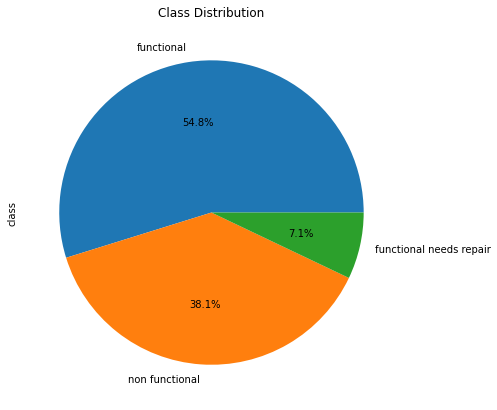

In [21]:
# Class Distribution

train_df['class'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(7,7))
plt.title('Class Distribution')
plt.show()

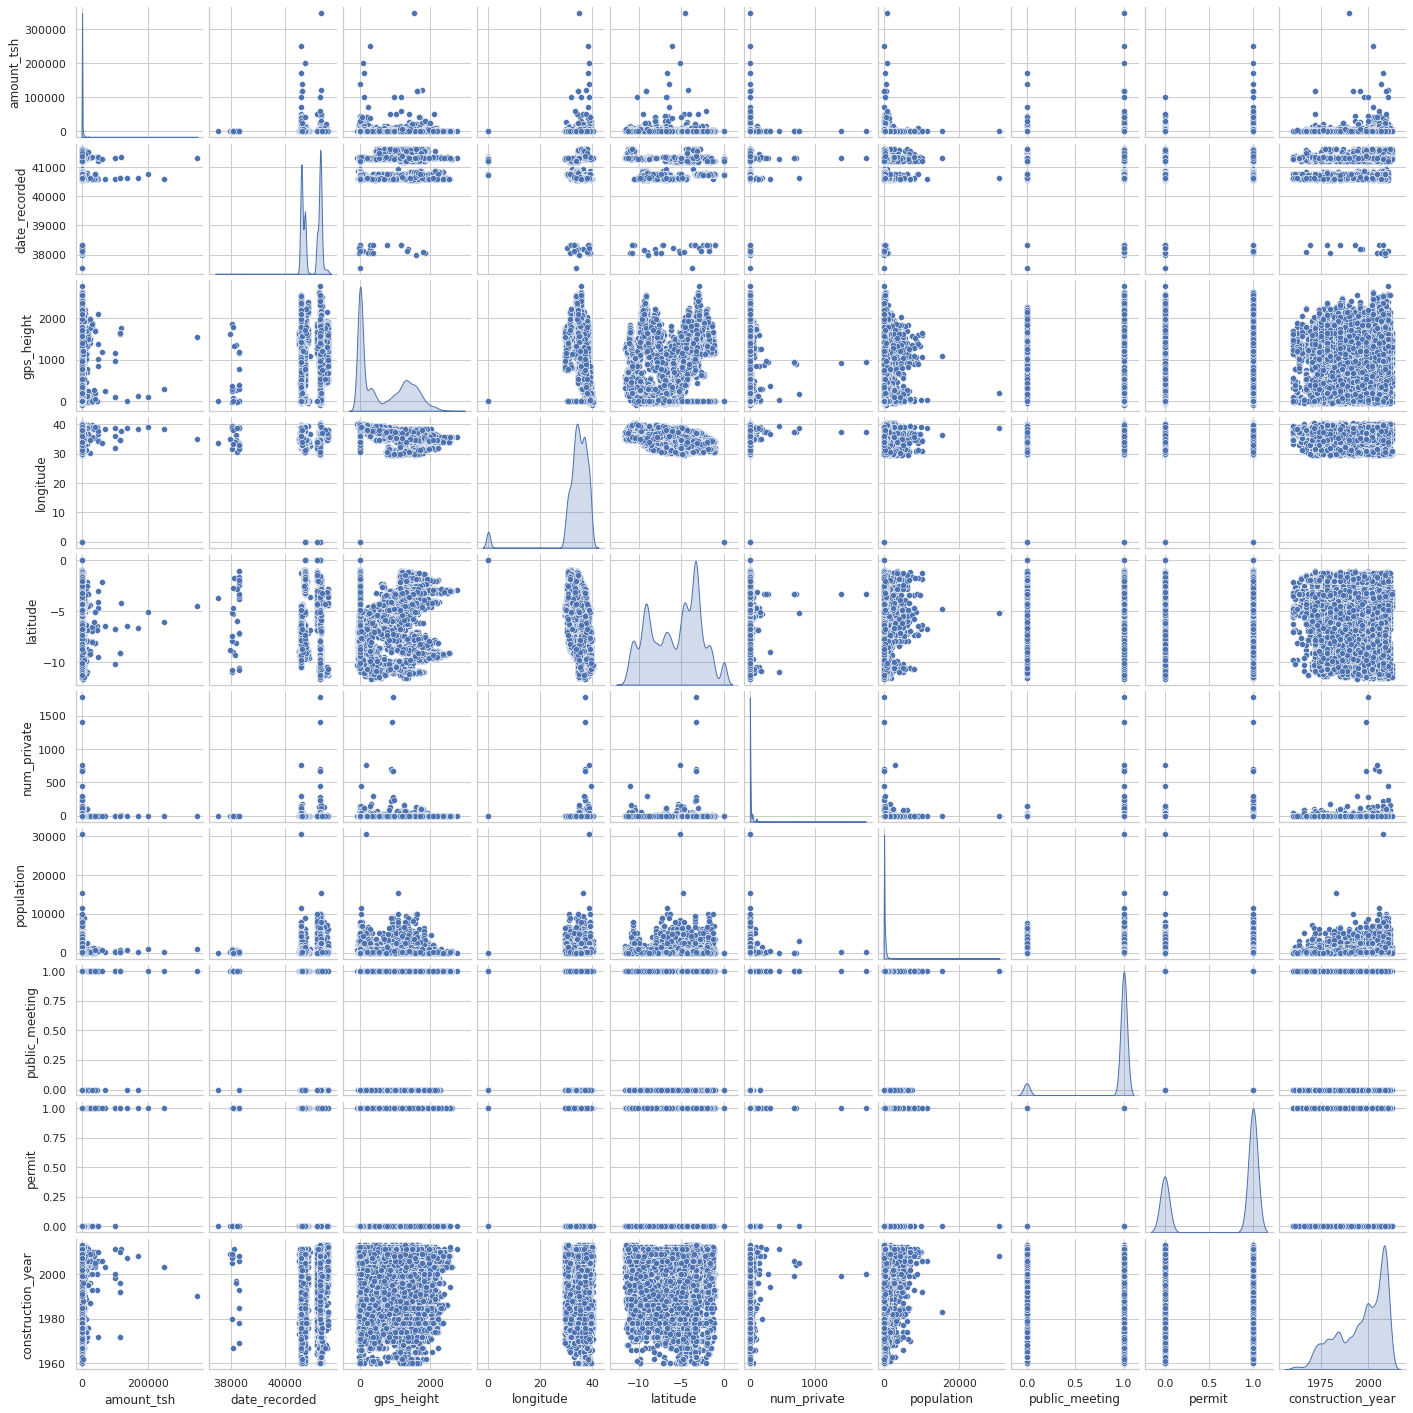

In [22]:
# Distribution and Scatter plots

eda_cols = train_df.select_dtypes(['number']).columns

sns.set(style='whitegrid',context = 'notebook')
sns.pairplot(train_df[eda_cols],height = 2,x_vars= eda_cols,y_vars=eda_cols,diag_kind='kde')


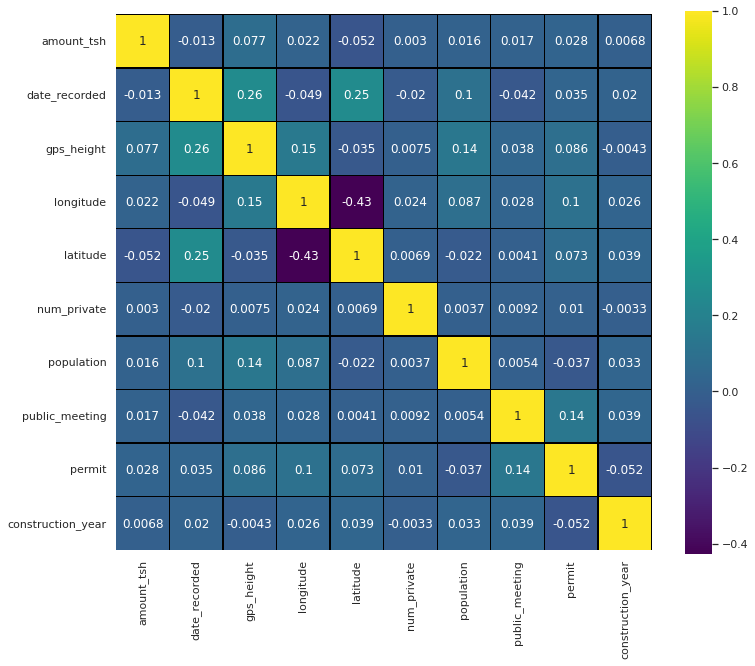

In [23]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(train_df.corr(),linewidths=0.25, square=True, cmap =plt.cm.viridis, linecolor='black', annot=True)

## Modeling

In [24]:
class Objective:
    
    def __init__(self):
        self.best_booster = None
        self._booster = None
    
    def __call__(self, trial, X, y):
        
        param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100,500,1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
        "num_leaves": trial.suggest_int('num_leaves', 64, 256),
        "max_depth": trial.suggest_int("max_depth", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 2000, step=100),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "lambda_l1": trial.suggest_loguniform('lambda_l1', 1e-8, 1),
        "lambda_l2": trial.suggest_loguniform('lambda_l2', 1e-8, 1),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 1),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 5),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.2, 0.8),
        "early_stopping_rounds": trial.suggest_categorical("early_stopping_rounds", [100]),
        }
        
        pipe1 = Pipeline(steps=[
        ('multi_encoder', multi_encoder()),
        ('modeler', LGBMClassifier(objective="multiclass", **param_grid, random_state=123))
        ])
        pipe0 = pipe1['multi_encoder']
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
        cv_scores = np.empty(5)
    
        for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
            X_train1, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train1, y_val = y[train_idx], y[val_idx]
        
            pipe0.fit(X_train1,y_train1) # to transform validation set
        
            pipe1.fit(
                X_train1,
                y_train1,
                modeler__eval_set=[(pipe0.transform(X_val),y_val)],
                modeler__eval_metric='multi_logloss',
                modeler__callbacks=[LightGBMPruningCallback(trial, 'multi_logloss')]
                )
            preds = pipe1.predict(X_val)
            cv_scores[idx] = accuracy_score(y_val, preds)
        
        self._booster = pipe1['modeler']
        
        return np.mean(cv_scores)


    def callback(self, study, trial):
        
        if study.best_trial == trial:
            self.best_booster = self._booster


In [25]:
def optuna_tuning(X, y):
    
    objective = Objective()

    study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                            direction='minimize', study_name='LGBM Classifier')
    func = lambda trial: objective(trial, X, y)
    study.optimize(func, n_trials=5000, callbacks=[objective.callback])

    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")   
    
    print('Best model accuracy: ',study.best_value)
    print('Best iterations: ',objective.best_booster.best_iteration_)
    
#optuna_tuning(X_train, y_train)

In [26]:
def gs_tuning(X, y):
    
    param_grid = {'modeler__n_estimators': [100],
                  'modeler__learning_rate': [0.22968707806239144],
                  'modeler__num_leaves': [249],
                  'modeler__max_depth': [12],
                  'modeler__min_data_in_leaf': [100],
                  'modeler__max_bin': [285],
                  'modeler__lambda_l1': [0.9857784137288985],
                  'modeler__lambda_l2': [0.00501489051635155],
                  'modeler__min_gain_to_split': [0.020502486331931025],
                  'modeler__bagging_fraction': [0.8984861088619291],
                  'modeler__bagging_freq': [1],
                  'modeler__feature_fraction': [0.6465732192300356],   
                 }

    pipe1 = Pipeline(steps=[
        ('multi_encoder', multi_encoder()),
        ('modeler', LGBMClassifier(objective="multiclass", random_state=123))
        ])
    
    gs_model = GridSearchCV(pipe1, param_grid, n_jobs = -1, cv=5, verbose=0, scoring='accuracy')
    gs_model.fit(X, y)

    print(gs_model.best_params_)
    print(gs_model.best_score_)
    
    with open('best_model_pipe', 'wb') as files:
        pickle.dump(gs_model.best_estimator_, files)

gs_tuning(X_train, y_train)

{'modeler__bagging_fraction': 0.8984861088619291, 'modeler__bagging_freq': 1, 'modeler__feature_fraction': 0.6465732192300356, 'modeler__lambda_l1': 0.9857784137288985, 'modeler__lambda_l2': 0.00501489051635155, 'modeler__learning_rate': 0.22968707806239144, 'modeler__max_bin': 285, 'modeler__max_depth': 12, 'modeler__min_data_in_leaf': 100, 'modeler__min_gain_to_split': 0.020502486331931025, 'modeler__n_estimators': 100, 'modeler__num_leaves': 249}
0.8176733791588264


In [27]:
## Final Pipeline

def evaluate_model():

    with open('best_model_pipe' , 'rb') as f:
        final_pipe = pickle.load(f)

    final_pipe.fit(X_train,y_train)

    # final predictions
    predictions = final_pipe.predict(X_test)

    ## Train Accuracy
    print('Train accuracy: ',accuracy_score(y_train, final_pipe.predict(X_train)))

    ## Cross Val Accuracy
    print('Validation accuracy: ',cross_val_score(final_pipe, X_train, y_train, cv=10, scoring= 'accuracy').mean())

    return predictions

pred = evaluate_model()

Train accuracy:  0.8876954290488125
Validation accuracy:  0.8212536881516123


                         precision    recall  f1-score   support

             functional       0.82      0.90      0.86     32143
functional needs repair       0.60      0.34      0.44      4145
         non functional       0.85      0.79      0.82     22365

               accuracy                           0.82     58653
              macro avg       0.76      0.68      0.71     58653
           weighted avg       0.82      0.82      0.81     58653



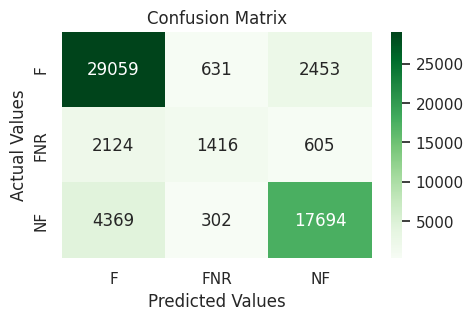

In [28]:
def display_results():

    with open('best_model_pipe' , 'rb') as f:
        final_pipe = pickle.load(f)

    y_pred = cross_val_predict(final_pipe, X_train, y_train, cv=10)
    
    # Print classification report
    print(classification_report(y_train, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_train, y_pred)

    plt.figure(figsize=(5,3), dpi=100)
    ax = sns.heatmap(cm, annot = True, fmt='d', xticklabels = ["F", "FNR", "NF"], yticklabels = ["F", "FNR", "NF"], cmap="Greens")
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.set_title("Confusion Matrix")
    plt.show()

display_results()

In [29]:
## Final Submission

def create_submission():

    submission = pd.DataFrame({"id":test_id, "status_group":pred})

    import time
    timestr = time.strftime("%Y%m%d-%H%M%S")

    filename = "lgbm_submission_"+timestr+".csv"

    submission.to_csv(pathname+filename,index= False)

create_submission()

In [30]:
## Leaderboard: 82.94%

## Best Submission: 81.70%